### If you cannot download the dataset from kaggle (next line), uncomment these lines and run them

In [2]:
# upload my kaggle json file that I provided
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mirabud","key":"c6d421602e9f3e72358ea2e3d6f59f35"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

### Downloading the dataset
I used a different dataset called FracAtlas dataset (https://www.kaggle.com/datasets/mahmudulhasantasin/fracatlas-original-dataset/data) - it is a dataset of X-Ray scans curated from the images collected from 3 major hospitals in Bangladesh. It contains 2 global labels: fractured and non-fractured bones, additionally containing fracture annotations for each fractured bone. The dataset includes 4,083 images, where 717 images with 922 instances of fractures.
This dataset could be easily used for binary segmentation with 2 classes (fractures and everything else); however, I wanted to work on multi-class segmentation with 3 classes: fractures, bones, and blank space.

In [7]:
#!/bin/bash
!kaggle datasets download mahmudulhasantasin/fracatlas-original-dataset

Dataset URL: https://www.kaggle.com/datasets/mahmudulhasantasin/fracatlas-original-dataset
License(s): CC0-1.0
 93% 300M/323M [00:00<00:00, 503MB/s]
100% 323M/323M [00:00<00:00, 524MB/s]


I used Keras for working with the model, because it is straightforward and also because I already have experience working with PyTorch and wanted to try Keras.
Additionally, I downloaded COCO because it was one of the formats of fracture annotations.

In [8]:
!pip install keras pycocotools pylabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00


In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
from zipfile import ZipFile
from tqdm import tqdm
from pylabel import importer
import csv
%matplotlib inline

from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D, BatchNormalization, Dropout, Lambda
from keras.utils import normalize, to_categorical
from keras.optimizers import Adam
from tensorflow.keras.metrics import *

#CSV files for splitting the train-test values later
train_csv = '/content/FracAtlas/FracAtlas/Utilities/Fracture Split/train.csv'
test_csv = '/content/FracAtlas/FracAtlas/Utilities/Fracture Split/test.csv'

Unzipping the dataset

In [10]:
dataset = "/content/fracatlas-original-dataset.zip"
with ZipFile(dataset, 'r') as zip_:
    zip_.extractall('/content/FracAtlas')

###Loading and analyzing annotations.
The annotations are stored in JSON format, containing with image information, such as size (width and height), bounding box points, category id and name, and class name.

In [11]:
path_to_annotations = "/content/FracAtlas/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
path_to_images = "/content/FracAtlas/FracAtlas/images/Fractured"

dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="Fracture_COCO")
dataset.df.head(5)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,/content/FracAtlas/FracAtlas/images/Fractured,IMG0000019.jpg,,1,2304,2880,,,1242.297030,929.108911,...,0,,,,,0,fractured,,,1
1,/content/FracAtlas/FracAtlas/images/Fractured,IMG0000025.jpg,,2,2880,2304,,,1466.504519,2010.557108,...,0,,,,,0,fractured,,,1
2,/content/FracAtlas/FracAtlas/images/Fractured,IMG0000044.jpg,,3,2304,2880,,,1426.511093,1072.013147,...,0,,,,,0,fractured,,,1
3,/content/FracAtlas/FracAtlas/images/Fractured,IMG0000057.jpg,,4,2304,2880,,,1130.613861,1119.207921,...,0,,,,,0,fractured,,,1
4,/content/FracAtlas/FracAtlas/images/Fractured,IMG0000058.jpg,,5,2304,2880,,,1190.019802,1349.702970,...,0,,,,,0,fractured,,,1


As you can see here, there are 717 images as was said above, but only 1 class - fractures itself.

In [12]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")
print(f"Path to annotations:\n{dataset.path_to_annotations}")

Number of images: 717
Number of classes: 1
Classes:['fractured']
Class counts:
cat_name
fractured    922
Name: count, dtype: int64
Path to annotations:
/content/FracAtlas/FracAtlas/Annotations/COCO JSON


Here we load annotations using COCO library to show it on a bone as an example.

In [13]:
coco = COCO('/content/FracAtlas/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json')
img_dir = '/content/FracAtlas/FracAtlas/images/Fractured'
image_id = 72

img = coco.imgs[image_id]

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


We show the immage from the path, and then get the id of the category of the annotation (it's always 0 because there is only 1 class); then we get the annotation id that is the same as image id and load annotation on the image

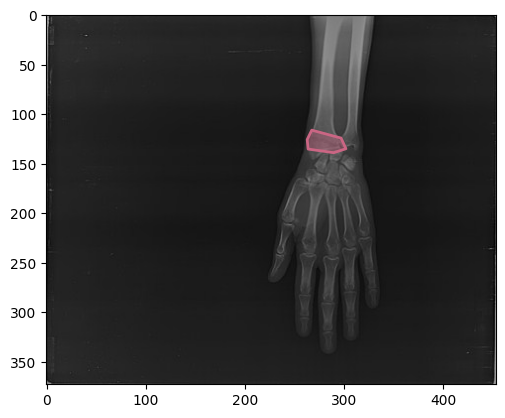

In [14]:
#Visualizes the annotation on an image
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

### Generating the masks
You can see that there is only 1 class, but I need to have 3: fractures, bones and blank space.

First, I generated the fracture masks from the annotations.

Here you can see that "COCO" library has itsown method "annToMask" where it converts annotation to mask. You can see the result below.

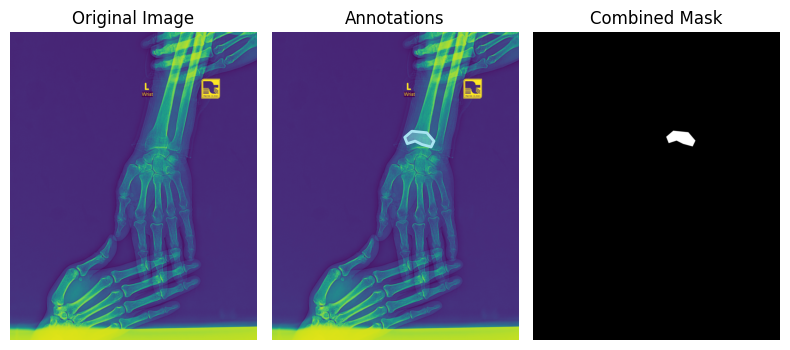

In [15]:
image_ids = coco.getImgIds()
num_images = 1
for i in range(num_images):
    img = coco.loadImgs(image_ids[i])[0]
    image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)

    mask = coco.annToMask(anns[0])
    for j in range(1, len(anns)):
        mask += coco.annToMask(anns[j])

    plt.figure(figsize=(8, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(image)
    coco.showAnns(anns)
    plt.axis('off')
    plt.title('Annotations')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Combined Mask')

    plt.tight_layout()
    plt.show()

Then I converted all annotations to masks:

For that, I got the bones image ids, got only the "fracture" category ids (there are only fractures, but it was a precuation), got the annotation ids and loaded them. After that the image with annotation got changed to the same size as the bones image and generated to masks. They are binary images to be easily segmented.

In [16]:
fracture_masks = '/content/FracAtlas/FracAtlas/images/fractures_masks'
os.makedirs(fracture_masks, exist_ok=True)
image_ids = coco.getImgIds()

for img_id in tqdm(image_ids, desc='Processing Images'):
    img = coco.loadImgs(img_id)[0]

    img_path = os.path.join(img_dir, img['file_name'])
    image = np.array(Image.open(img_path))

    cat_ids = coco.getCatIds(catNms=['fracture'])
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)

    mask = np.zeros((img['height'], img['width']), dtype=np.uint8)

    for j in range(len(anns)):
        mask += coco.annToMask(anns[j])

    mask[mask > 0] = 255

    mask_image = Image.fromarray(mask)
    mask_filename = img['file_name'].replace('.jpg', '_mask.png')
    mask_image.save(os.path.join(fracture_masks, mask_filename))

print("Generated fracture masks: ", len(os.listdir(fracture_masks)))


Processing Images: 100%|██████████| 717/717 [00:16<00:00, 43.81it/s] 

Generated fracture masks:  717


### Generating the masks from the bones & Combining the masks
There was a challenge: initially, I created masks of the bones first and only then applied the fractures masks, so when I trained the model, the accuracy showed 95% in 20 epochs, but the model didn't notice the fracture at all: because the fracture is hardly seen by itself and because my mask of the bone covered the fracture area, so model classified it as the bone.

To solve it, I first generate masks from fracture annotations and then generated masks of the bones by taking the fracture masks out.

Below you can see that I tried several thresholding methods to generate the masks: Otsu and Li. I use Otsu thresholding first, because it works well with X-Ray and biomedical images. With Otsu we don't need to put threshold value, it does it automatically and with grayscale images (which X-Ray and biomedical images usually are), it sees clear difference, because such images are bimodal (only two distinct image values).

In [17]:
img = cv2.imread("/content/FracAtlas/FracAtlas/images/Fractured/IMG0000019.jpg", cv2.IMREAD_GRAYSCALE)
_, bone_mask = cv2.threshold(img, 70, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imwrite("bone_mask_otsu.png", bone_mask)

True

Then I found threshold functions from skimage (scikit-image) - image processing/computer vision library.

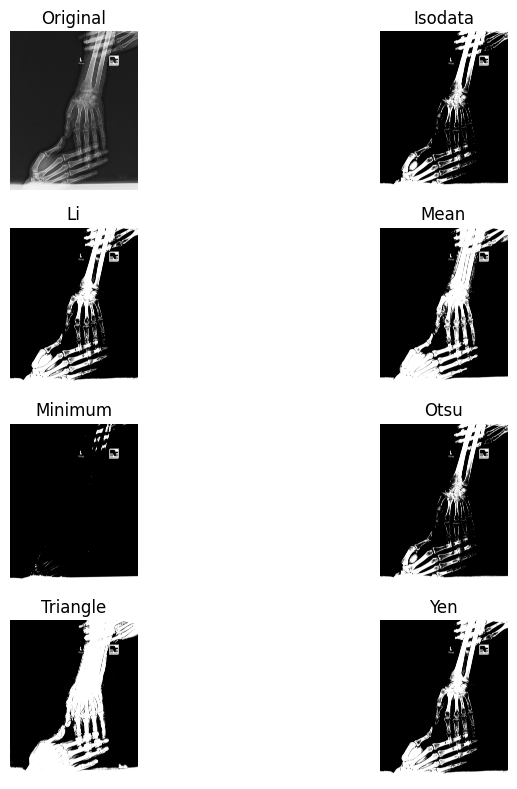

In [18]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

You can see above that Li and Yen make identically more detailed masks than Otsu, that's why I decided to try Li on the images. The authors of this threshold proposed minimizing cross-entropy between the foreground and foreground mean / background and background mean for better thresholding.

This method outputs a single value, that's why I then apply it to the image to generate a binary value.

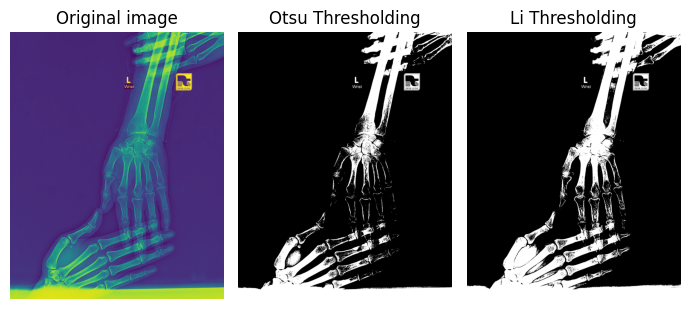

In [19]:
from skimage.filters import threshold_li

image_li = threshold_li(img)
image_mask_li = img > image_li

image_mask_otsu = cv2.imread("/content/bone_mask_otsu.png", cv2.IMREAD_GRAYSCALE)
if len(image_mask_otsu.shape) == 3:
    image_mask_otsu = cv2.cvtColor(image_mask_otsu, cv2.COLOR_BGR2GRAY)
img = cv2.imread("/content/FracAtlas/FracAtlas/images/Fractured/IMG0000019.jpg", cv2.IMREAD_GRAYSCALE)
if len(img.shape) == 3 and img.shape[2] == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(7, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_mask_otsu, cmap='gray')
plt.title('Otsu Thresholding')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_mask_li, cmap='gray')
plt.title('Li Thresholding')
plt.axis('off')
plt.tight_layout()
plt.show()

I actually did the whole training with bone masks that were generated with Otsu thresholding. The results were good, 92% for 20 epochs, but Li threshold-generated masks showed better results - 95% for the same amount (both results still didn't see the fractures), so I decided to keep only them, because it would be too much in one notebook.

As I said above, initially I generated masks of the bone taking the fracture with it. I fixed it, and below you can see that we take the original image first, resize it, then apply Li threshold, then read and resize fracture mask image, and take it out from bone mask image, generating the pixel 1 to 255 to be able to display images.

In [20]:
from skimage.filters import threshold_li
from skimage.io import imread, imsave

bone_masks = "/content/FracAtlas/FracAtlas/images/bones_masks"
os.makedirs(bone_masks, exist_ok=True)

size = (256, 256)

for file in tqdm(os.listdir(path_to_images), desc="Processing Bone Masks"):
    image_path = os.path.join(path_to_images, file)
    fracture_mask_path = os.path.join(fracture_masks, file.replace(".jpg", "_mask.png"))
    #Get and resize original bone images
    img = imread(image_path, as_gray=True)
    img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
    #Apply Li threshold
    li_thresh = threshold_li(img)
    bone_mask = img > li_thresh
    bone_mask = bone_mask.astype(np.uint8)
    #Get, resize, and converting 255 to 1 to calculate the difference
    fracture_mask = imread(fracture_mask_path, as_gray=True)
    fracture_mask = cv2.resize(fracture_mask, size, interpolation=cv2.INTER_NEAREST)
    fracture_mask = (fracture_mask == 255).astype(np.uint8)
    #Take out the fracture mask and convert to 255 again
    bone_mask = np.clip(bone_mask - fracture_mask, 0, 1)
    bone_mask *= 255

    output_path = os.path.join(bone_masks, file.replace(".jpg", ".png"))
    imsave(output_path, bone_mask)

Processing Bone Masks: 100%|██████████| 717/717 [00:15<00:00, 46.19it/s]


Here you can see that the fracture mask (the circle on the wrist) is not masked

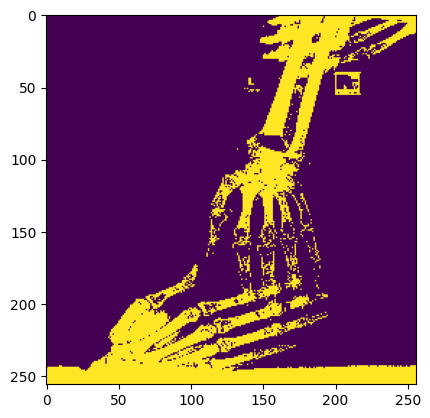

In [21]:
bone_without_fracture = cv2.imread('/content/FracAtlas/FracAtlas/images/bones_masks/IMG0000019.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(bone_without_fracture)
plt.show()

Here I combined the masks alltogether and converted the pixels to 1 and 2 (bones and fractures) to have classes.

0 - Blank space
1 - Bone
2 - Fracture

In [22]:
combined_masks = "/content/FracAtlas/FracAtlas/images/combined_masks"
os.makedirs(combined_masks, exist_ok=True)

bone_mask_files = os.listdir(bone_masks)

for file in tqdm(bone_mask_files, desc="Processing Masks"):
    bone_mask_path = os.path.join(bone_masks, file)

    filename_base = os.path.splitext(file)[0]
    fracture_mask_filename = f"{filename_base}_mask.png"
    fracture_mask_path = os.path.join(fracture_masks, fracture_mask_filename)

    bone_mask = cv2.imread(bone_mask_path, cv2.IMREAD_GRAYSCALE)
    if bone_mask is None:
        print(f"Warning: Bone mask {file} not found! Skipping...")
        continue

    fracture_mask = cv2.imread(fracture_mask_path, cv2.IMREAD_GRAYSCALE)
    if fracture_mask is None:
        print(f"Warning: Fracture mask {file} not found! Skipping...")
        continue
    #Resize the image if it's not the same shape as bone mask image
    if bone_mask.shape != fracture_mask.shape:
        fracture_mask = cv2.resize(fracture_mask, (bone_mask.shape[1], bone_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    #Convert the 255 to 1
    bone_mask = (bone_mask == 255).astype(np.uint8)
    fracture_mask = (fracture_mask == 255).astype(np.uint8)
    #Setting the pixels categorically
    combined_mask = np.zeros_like(bone_mask, dtype=np.uint8)
    combined_mask[np.where(bone_mask == 1)] = 1
    combined_mask[np.where(fracture_mask == 1)] = 2

    #print("Unique values in combined mask:", np.unique(combined_mask))
    output_path = os.path.join(combined_masks, file)
    Image.fromarray(combined_mask).convert("L").save(output_path, format="PNG")

print("Multi-class mask generation completed!")

Processing Masks: 100%|██████████| 717/717 [00:03<00:00, 226.49it/s]

Multi-class mask generation completed!


This is how combined masks look like

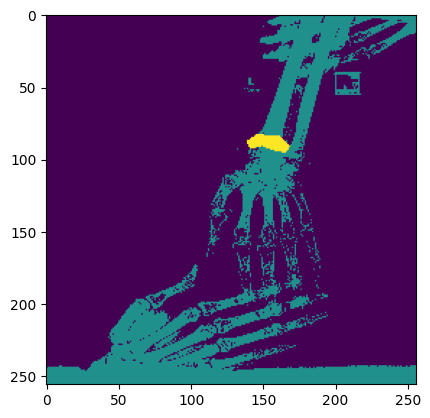

In [23]:
combined_mask = cv2.imread('/content/FracAtlas/FracAtlas/images/combined_masks/IMG0000019.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(combined_mask)
plt.show()

### Additional data preprocessing
My second (and biggest) challenge: class imbalance.

As you remember, the dataset has only 1 class: fractures, I made masks of the bones myself and blank space was everything else. Because of that, X_train and X_test did not have 3 classes, only 2 (fractures and everything else) and it was the reason why my model worked good, but did not see any fracture mask on the picture (because it recognized the whole bone as fracture). Below I am solving this issue.

I added images to array and  converted them to np array first. The dataset already contained the CSV files with the names of images for training and testing, I used them.

In [24]:
train_images = []
train_masks = []
with open(train_csv, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:
        fractured_images_path = os.path.join(path_to_images, row[0])
        fractured_image = cv2.imread(fractured_images_path, cv2.IMREAD_GRAYSCALE)
        if fractured_image is None:
          print(f"Fractured image {file} not found!")
          continue
        fractured_image = cv2.resize(fractured_image, size, interpolation = cv2.INTER_NEAREST)
        train_images.append(fractured_image)

        filename_base = row[0].split(".")[0]
        masks_image_filename = f"{filename_base}.png"
        masks_path = os.path.join(combined_masks, masks_image_filename)
        masks = cv2.imread(masks_path, cv2.IMREAD_GRAYSCALE)
        if masks is None:
          print(f"Mask {file} not found!")
          continue
        train_masks.append(masks)
train_images = np.array(train_images)
train_masks = np.array(train_masks)

Fractured image IMG0002440.png not found!


In [25]:
test_images = []
test_masks = []
with open(test_csv, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:
        fractured_images_path = os.path.join(path_to_images, row[0])
        fractured_image = cv2.imread(fractured_images_path, cv2.IMREAD_GRAYSCALE)
        if fractured_image is None:
          print(f"Fractured image {file} not found! Skipping...")
          continue
        fractured_image = cv2.resize(fractured_image, size, interpolation = cv2.INTER_NEAREST)
        test_images.append(fractured_image)

        filename_base = row[0].split(".")[0]
        masks_image_filename = f"{filename_base}.png"
        masks_path = os.path.join(combined_masks, masks_image_filename)
        masks = cv2.imread(masks_path, cv2.IMREAD_GRAYSCALE)
        if masks is None:
          print(f"Mask {file} not found! Skipping...")
          continue
        test_masks.append(masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

Fractured image IMG0002440.png not found! Skipping...


Here I am using existing mask to retrieve the bone masks, converting it to white and overlaying it on the original images.

In [26]:
for i in range(len(train_images)):
    bone_mask = train_masks[i]
    bone_overlay = (bone_mask == 1) * 255
    train_images[i] = cv2.addWeighted(train_images[i], 0.8, bone_overlay.astype(np.uint8), 0.2, 0)

    fracture_mask = train_masks[i] == 2
    fracture_overlay = (fracture_mask * 255).astype(np.uint8)
    train_images[i] = cv2.addWeighted(train_images[i], 0.8, fracture_overlay, 0.2, 0)

In [27]:
for i in range(len(test_images)):
    bone_mask = test_masks[i]
    bone_overlay = (bone_mask == 1) * 255
    test_images[i] = cv2.addWeighted(test_images[i], 0.8, bone_overlay.astype(np.uint8), 0.2, 0)

    fracture_mask = test_masks[i] == 2
    fracture_overlay = (fracture_mask * 255).astype(np.uint8)
    test_images[i] = cv2.addWeighted(test_images[i], 0.8, fracture_overlay, 0.2, 0)

In [28]:
print(np.unique(test_masks, return_counts=True))

(array([0, 1, 2], dtype=uint8), array([3210106,  774697,   12893]))


Then I expanded the dimensions of all arrays, because U-Net expects a 4D input shape.

In [29]:
train_images_expanded = np.expand_dims(train_images, axis=3)/255.0
train_masks_expanded = np.expand_dims(train_masks, axis=3)

test_images_expanded = np.expand_dims(test_images, axis=3)/255.0
test_masks_expanded = np.expand_dims(test_masks, axis=3)

In [30]:
X_train = train_images_expanded
X_test = test_images_expanded
y_train = train_masks_expanded
y_test = test_masks_expanded

print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2]


In [31]:
n_classes=3

Now I need to convert my masks to categorical type of data, because without it, the model would consider them as continous numbers.

In [32]:
y_train[y_train == 255] = 2
y_test[y_test == 255] = 2

In [33]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [34]:
print(np.unique(np.argmax(y_train_cat, axis=-1)))

[0 1 2]


### U-Net multiclass model using Keras
The paper was very helpful in understanding the U-Net architecture.

In the code it is clearly seen that the network consists of a contracting path (encoder) that captures spatial features through convolution and max pooling, and an expanding path (decoder) that upscales the features using transposed convolutions and skip connections.

For the output layer, I use softmax activation, because it is commonly used with categorical cross-entropy loss and it assigns a pixel to each class by choosing the highest probability.

In [35]:
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contracting path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expanding path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

### Compiling the model

In the output you can see the model and that we upsample the features and then downsample them for the output result.

In [36]:
import keras
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.MeanIoU(num_classes=3)])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,940,851 (7.40 MB)

 Trainable params: 1,940,851 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [70]:
# Calculate sample weights based on class weights
class_weights = {0: 1.0, 1: 1.0, 2: 5.0}
sample_weights = np.zeros_like(y_train, dtype=np.float32)
for class_id, weight in class_weights.items():
    sample_weights[y_train == class_id] = weight

with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train_cat,
                        batch_size = 16,
                        verbose=1,
                        epochs=50,
                        validation_data=(X_test, y_test_cat),
                        sample_weight=sample_weights,
                        shuffle=False)

model.save('unet-1.keras')

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9946 - loss: 0.0191 - mean_io_u: 0.7480 - val_accuracy: 0.9944 - val_loss: 0.0200 - val_mean_io_u: 0.8199
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9963 - loss: 0.0140 - mean_io_u: 0.7624 - val_accuracy: 0.9955 - val_loss: 0.0181 - val_mean_io_u: 0.8248
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9967 - loss: 0.0125 - mean_io_u: 0.7741 - val_accuracy: 0.9946 - val_loss: 0.0198 - val_mean_io_u: 0.8201
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9968 - loss: 0.0119 - mean_io_u: 0.7690 - val_accuracy: 0.9946 - val_loss: 0.0218 - val_mean_io_u: 0.8257
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9969 - loss: 0.0113 - mean_io_u: 0.7775 - val_accuracy: 0.9938 - val_loss: 0.0271 - val_mean_io_u: 0.8250
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9970 - loss: 0.0112 - mean_io_u: 0.7716 - val_accuracy: 0.9951 - val_loss:

### Results

In [71]:
loss, acc, mean_iou = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")
print("Mean IoU is = ", (mean_iou),)
print("Loss is = ", (loss),)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9955 - loss: 0.0235 - mean_io_u: 0.8342
Accuracy is =  99.5919406414032 %
Mean IoU is =  0.8364602327346802
Loss is =  0.020806577056646347


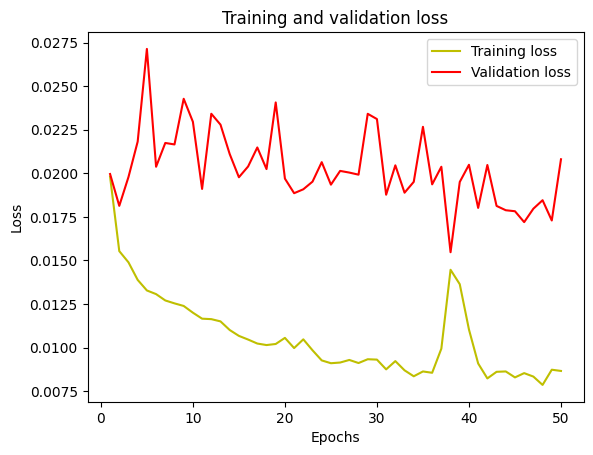

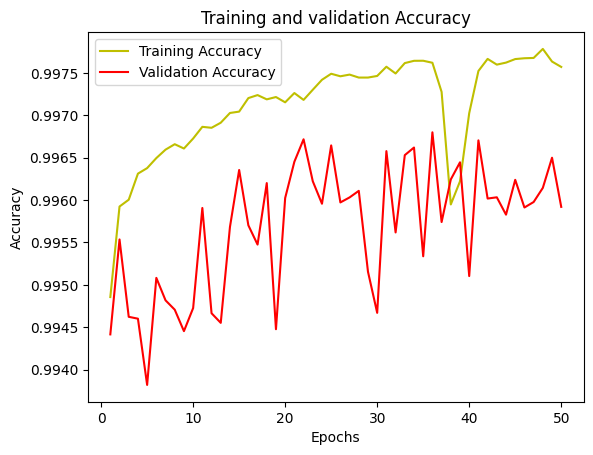

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [73]:
import tensorflow as tf

iou_metric = tf.keras.metrics.MeanIoU(num_classes=3)

y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_true = np.argmax(y_test_cat, axis=3)
iou_metric.update_state(y_true, y_pred_argmax)

#Confusion matrix
conf_matrix = iou_metric.total_cm.numpy()
print("Confusion Matrix:\n", conf_matrix)

#IOU for each class
iou_per_class = np.diag(conf_matrix) / (np.sum(conf_matrix, axis=1) + np.sum(conf_matrix, axis=0) - np.diag(conf_matrix))

for class_id, iou in enumerate(iou_per_class):
    print(f"IoU for class {class_id}: {iou:.4f}")

mean_iou = iou_metric.result().numpy()
print(f"Mean IoU: {mean_iou:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Confusion Matrix:
 [[3210050      54       2]
 [   3638  766931    4128]
 [      5    8486    4402]]
IoU for class 0: 0.9988
IoU for class 1: 0.9792
IoU for class 2: 0.2586
Mean IoU: 0.7455


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


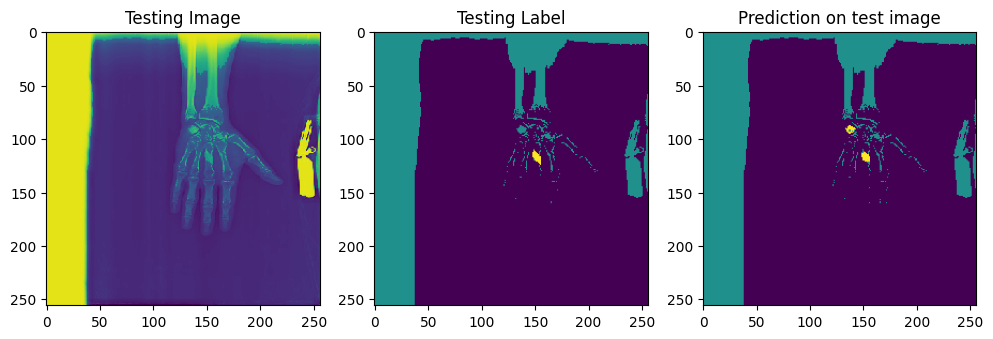

In [75]:
test_img = X_test[5]
ground_truth=y_test[5]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])

plt.subplot(2, 3, 2)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap="viridis")

plt.subplot(2, 3, 3)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap="viridis")
plt.show()

###Conclusions
As you can see in the results, the training accuracy is very high (99%), and the mean IOU is okay (83%), but you can see that the fracture is being segmented very poorly. There are likely 2 reasons for that: insufficient pre-processing and amount of training data (only 574 images). You can see above that the testing label is not seen clearly, so either thresholding doesn't work well, or it is not enough. I think adding morphological transformation would have made the labels at least a bit better.

One of the main challenges was preparing the dataset, as the original images contained only fractures. To address this, I generated bone masks using Li thresholding and separated of bone and fracture classes. Additionally, class imbalance initially caused the model to ignore fractures, which required to balance the dataset by adding weights to improve performance.

#References:
https://arxiv.org/pdf/1505.04597
https://www.kaggle.com/code/mahmudulhasantasin/annotation-to-masks-generation
https://scikit-image.org/docs/0.20.x/auto_examples/developers/plot_threshold_li.html
https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
https://keras.io/guides/custom_train_step_in_tensorflow/
https://www.tensorflow.org/api_docs/python/tf/keras/metrics/IoU
https://www.geeksforgeeks.org/numpy-argmax-python/
https://www.kaggle.com/code/saidislombek/biomedical-image-segmentation-with-u-net/notebook
